In [7]:
# Link to paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9971386
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.io import read_image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from isar_dataset import ISARDataset

## Model Definitions

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
class CNN(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            ConvBlock(in_channels, 8),
            ConvBlock(8, 8),
            ConvBlock(8, 8),
            ConvBlock(8, 8),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ConvBlock(8, 16),
            ConvBlock(16, 16),
            ConvBlock(16, 16),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ConvBlock(16, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        return x

In [9]:
class BiLSTM(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = 2
        self.lstm = nn.LSTM(2592, self.hidden_size, self.num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(self.hidden_size * 2, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states (only needs to be done once)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM
        out, _ = self.lstm(x, (h0, c0))  

        # Extract last hidden state
        return out[:, -1, :]

class CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.cnn = CNN()
        hidden_size = 1000
        self.bilstm = BiLSTM(hidden_size, num_classes)
        self.fc1 = nn.Linear(2 * hidden_size, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        B, seq_length, C, H, W = x.shape

        # Process images in sequence via CNN independently
        cnn_out = []
        for i in range(seq_length):
            img = x[:, i, :, :, :]
            img = self.cnn(img)
            img = img.flatten(1)
            cnn_out.append(img)
        x = torch.stack(cnn_out, dim=1)
        
        x = self.bilstm(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

## Training

In [10]:
# 0. Declare constants
NUM_CLASSES = 4
MODEL_PATH = 'weights/cnn_bilstm_model.pth'

# Hyperparameters
SEQ_LENGTH = 3
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
NUM_EPOCHS=50

# 1. Data Preparation
center_crop = transforms.CenterCrop((120, 120))

# TODO: Sampler instead of logic within dataloader -- faster, cleaner
train_dataset = ISARDataset('test/test_labels.csv', 'test/data/', seq_length=SEQ_LENGTH, transform=center_crop)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 2. Model and Optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_BiLSTM(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 3. Training Loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward, backward pass + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Print batch statistics
        # if (i + 1) % 2 == 0:
        #     print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}] - Average Loss: {running_loss / len(train_loader):.4f}') # Accuracy: 100 * correct / total:.2f


torch.save(model.state_dict(), MODEL_PATH)

Epoch 1/50: 100%|██████████| 8/8 [00:09<00:00,  1.23s/batch]


Epoch [1/50] - Average Loss: 1.5179


Epoch 2/50: 100%|██████████| 8/8 [00:10<00:00,  1.28s/batch]


Epoch [2/50] - Average Loss: 1.3729


Epoch 3/50: 100%|██████████| 8/8 [00:09<00:00,  1.19s/batch]


Epoch [3/50] - Average Loss: 1.2486


Epoch 4/50: 100%|██████████| 8/8 [00:09<00:00,  1.18s/batch]


Epoch [4/50] - Average Loss: 1.1736


Epoch 5/50: 100%|██████████| 8/8 [00:09<00:00,  1.21s/batch]


Epoch [5/50] - Average Loss: 1.1508


Epoch 6/50: 100%|██████████| 8/8 [00:10<00:00,  1.35s/batch]


Epoch [6/50] - Average Loss: 1.1355


Epoch 7/50: 100%|██████████| 8/8 [00:12<00:00,  1.54s/batch]


Epoch [7/50] - Average Loss: 1.1032


Epoch 8/50: 100%|██████████| 8/8 [00:12<00:00,  1.55s/batch]


Epoch [8/50] - Average Loss: 1.0885


Epoch 9/50: 100%|██████████| 8/8 [00:10<00:00,  1.36s/batch]


Epoch [9/50] - Average Loss: 1.0079


Epoch 10/50: 100%|██████████| 8/8 [00:10<00:00,  1.32s/batch]


Epoch [10/50] - Average Loss: 0.9551


Epoch 11/50: 100%|██████████| 8/8 [00:13<00:00,  1.63s/batch]


Epoch [11/50] - Average Loss: 0.9149


Epoch 12/50: 100%|██████████| 8/8 [00:13<00:00,  1.67s/batch]


Epoch [12/50] - Average Loss: 0.8959


Epoch 13/50: 100%|██████████| 8/8 [00:12<00:00,  1.55s/batch]


Epoch [13/50] - Average Loss: 0.8856


Epoch 14/50: 100%|██████████| 8/8 [00:11<00:00,  1.46s/batch]


Epoch [14/50] - Average Loss: 0.8796


Epoch 15/50: 100%|██████████| 8/8 [00:11<00:00,  1.38s/batch]


Epoch [15/50] - Average Loss: 0.8754


Epoch 16/50: 100%|██████████| 8/8 [00:12<00:00,  1.53s/batch]


Epoch [16/50] - Average Loss: 0.8722


Epoch 17/50: 100%|██████████| 8/8 [00:19<00:00,  2.38s/batch]


Epoch [17/50] - Average Loss: 0.8704


Epoch 18/50: 100%|██████████| 8/8 [00:21<00:00,  2.74s/batch]


Epoch [18/50] - Average Loss: 0.8696


Epoch 19/50: 100%|██████████| 8/8 [00:16<00:00,  2.12s/batch]


Epoch [19/50] - Average Loss: 0.8693


Epoch 20/50: 100%|██████████| 8/8 [00:15<00:00,  1.99s/batch]


Epoch [20/50] - Average Loss: 0.8691


Epoch 21/50: 100%|██████████| 8/8 [00:14<00:00,  1.81s/batch]


Epoch [21/50] - Average Loss: 0.8689


Epoch 22/50: 100%|██████████| 8/8 [00:11<00:00,  1.42s/batch]


Epoch [22/50] - Average Loss: 0.8688


Epoch 23/50: 100%|██████████| 8/8 [00:11<00:00,  1.43s/batch]


Epoch [23/50] - Average Loss: 0.8687


Epoch 24/50: 100%|██████████| 8/8 [00:11<00:00,  1.40s/batch]


Epoch [24/50] - Average Loss: 0.8686


Epoch 25/50: 100%|██████████| 8/8 [00:09<00:00,  1.18s/batch]


Epoch [25/50] - Average Loss: 0.8684


Epoch 26/50: 100%|██████████| 8/8 [00:11<00:00,  1.46s/batch]


Epoch [26/50] - Average Loss: 0.8683


Epoch 27/50: 100%|██████████| 8/8 [00:12<00:00,  1.58s/batch]


Epoch [27/50] - Average Loss: 0.8680


Epoch 28/50: 100%|██████████| 8/8 [00:10<00:00,  1.25s/batch]


Epoch [28/50] - Average Loss: 0.8677


Epoch 29/50: 100%|██████████| 8/8 [00:09<00:00,  1.20s/batch]


Epoch [29/50] - Average Loss: 0.8673


Epoch 30/50: 100%|██████████| 8/8 [00:09<00:00,  1.24s/batch]


Epoch [30/50] - Average Loss: 0.8660


Epoch 31/50: 100%|██████████| 8/8 [00:12<00:00,  1.56s/batch]


Epoch [31/50] - Average Loss: 0.8650


Epoch 32/50: 100%|██████████| 8/8 [00:09<00:00,  1.15s/batch]


Epoch [32/50] - Average Loss: 0.8603


Epoch 33/50: 100%|██████████| 8/8 [00:10<00:00,  1.29s/batch]


Epoch [33/50] - Average Loss: 0.8595


Epoch 34/50: 100%|██████████| 8/8 [00:11<00:00,  1.38s/batch]


Epoch [34/50] - Average Loss: 0.8460


Epoch 35/50: 100%|██████████| 8/8 [00:10<00:00,  1.36s/batch]


Epoch [35/50] - Average Loss: 0.8321


Epoch 36/50: 100%|██████████| 8/8 [00:11<00:00,  1.40s/batch]


Epoch [36/50] - Average Loss: 0.8137


Epoch 37/50: 100%|██████████| 8/8 [00:11<00:00,  1.44s/batch]


Epoch [37/50] - Average Loss: 0.7952


Epoch 38/50: 100%|██████████| 8/8 [00:10<00:00,  1.37s/batch]


Epoch [38/50] - Average Loss: 0.7760


Epoch 39/50: 100%|██████████| 8/8 [00:09<00:00,  1.25s/batch]


Epoch [39/50] - Average Loss: 0.7602


Epoch 40/50: 100%|██████████| 8/8 [00:11<00:00,  1.44s/batch]


Epoch [40/50] - Average Loss: 0.7514


Epoch 41/50: 100%|██████████| 8/8 [00:11<00:00,  1.43s/batch]


Epoch [41/50] - Average Loss: 0.7464


Epoch 42/50: 100%|██████████| 8/8 [00:11<00:00,  1.44s/batch]


Epoch [42/50] - Average Loss: 0.7448


Epoch 43/50: 100%|██████████| 8/8 [00:10<00:00,  1.37s/batch]


Epoch [43/50] - Average Loss: 0.7443


Epoch 44/50: 100%|██████████| 8/8 [00:09<00:00,  1.20s/batch]


Epoch [44/50] - Average Loss: 0.7439


Epoch 45/50: 100%|██████████| 8/8 [00:10<00:00,  1.30s/batch]


Epoch [45/50] - Average Loss: 0.7438


Epoch 46/50: 100%|██████████| 8/8 [00:10<00:00,  1.36s/batch]


Epoch [46/50] - Average Loss: 0.7438


Epoch 47/50: 100%|██████████| 8/8 [00:10<00:00,  1.29s/batch]


Epoch [47/50] - Average Loss: 0.7437


Epoch 48/50: 100%|██████████| 8/8 [00:12<00:00,  1.57s/batch]


Epoch [48/50] - Average Loss: 0.7437


Epoch 49/50: 100%|██████████| 8/8 [00:10<00:00,  1.33s/batch]


Epoch [49/50] - Average Loss: 0.7437


Epoch 50/50: 100%|██████████| 8/8 [00:13<00:00,  1.68s/batch]


Epoch [50/50] - Average Loss: 0.7437


Prediction: Class 0
Probability: 1.00


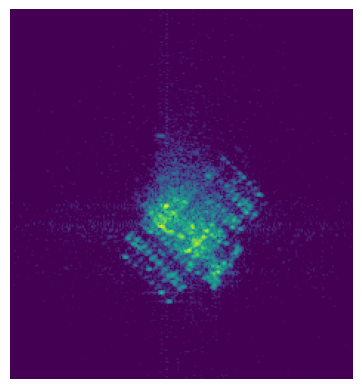

In [32]:
IMG_PATH = 'data/raw/image_50.png'

image = read_image(IMG_PATH).float()
plt.imshow(image.permute(1, 2, 0).int())
plt.axis('off')

saved_model = CNN_BiLSTM(num_classes=4)
saved_model.load_state_dict(torch.load(MODEL_PATH))
saved_model.eval()

# Add batch and sequence dimensions
image = center_crop(image).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    output = saved_model(image)
    prediction = torch.argmax(output, dim=1).item()
    print(f'Prediction: Class {prediction}')
    print(f'Probability: {output[0][prediction]:.2f}')